## CAPSTONE PROJECT - THE BATTLE OF THE NEIGHBOURHOODS

### TABLE OF CONTENTS

1. [Business Problem and Data](#introduction)
2. [Statistics Data Extraction and Exploration](#data)
3. [Venues Data and K-Mean Clustering](#clustering)
4. [House Price Reasoning with Random Forest](#randomforest)
5. [Conclusions](#conclusions)

### 1. BUSINESS PROBLEM AND DATA <a name='introduction'></a>

According to The Economist Intelligence Unit, Calgary is among the top five most livable cities globally and the most livable city in North America in the last two years. Every year, Calgary attracts tens of thousands of interprovincial and international migrants. Information about each neighbourhood of the city will be very helpful for newcomers whether they come to study, work, or start new business. 
<br>
<br>
This project aims to provide insight information about Calgary’s neighbourhoods, cluster neighbourhoods based on their venies, and roughly identify which variables driving house price and neighbourhoods where houses are likely overpriced. Hopefully, this work will help to point newcomers to the right direction and avoid costly mistakes when settling in Calgary. 
<br>
<br>
Data are extracted from public sources listed below: 
* Postal codes and coordinates of neighbourhoods: GeoNames and Mapawi
* Venue: Foursquare
* Community boundaries: Statistics Canada Boundary File
* Community population and area: Wikipedia
* House price data: The Globe and Mail House Price Data Centre
* Crime Rates: Calgary Police Statistical Reports
* School ratings: Fraser Institute School Rankings



### Libraries Import 

In [1203]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import re

from geopy.geocoders import Nominatim
import folium

import json
# from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split

### 2. STATISTICS DATA EXTRACTION AND EXPLORATION<a name='data'></a>

#### 2.1. Postal Code and Coordinates

##### Data Retrieval from GeoNames

In [3]:
url = 'https://www.geonames.org/postalcode-search.html?q=calgary&country=CA&adminCode1=AB'
req = requests.get(url)
html_data = req.text

In [4]:
soup = BeautifulSoup(html_data,'html.parser')

In [5]:
data = []
for tr in soup.findAll('table',{'class':'restable'}): 
    data = np.append(data,tr.text.split('\n'))
data = list(filter(None,data)) 
data[:5]

['PlaceCodeCountryAdmin1Admin2Admin3',
 '1Calgary (City Centre / Calgary Tower)T2PCanadaAlbertaCalgary\xa0\xa0\xa051.071/-113.693',
 '2Calgary (Cranston)T3MCanadaAlbertaCalgary\xa0\xa0\xa050.88/-113.955',
 '3Calgary NortheastT3NCanadaAlbertaCalgary\xa0\xa0\xa051.163/-113.954',
 '4Calgary NorthwestT3RCanadaAlbertaCalgary\xa0\xa0\xa051.202/-114.245']

In [6]:
neighbourhood = []
postalcode = []
lat = []
long = []

for item in data[1:]: 
    lat = np.append(lat, item.split()[-1].split('/')[0])
    long = np.append(long, item.split()[-1].split('/')[-1])
    postalcode = np.append(postalcode, re.findall(r'T[0-9][A-Z]',item))
    
    if len(re.findall(r'\(.*\)',item))==0: 
        neighbourhood = np.append(neighbourhood, re.findall(r'[A-Z,a-z]+T[0-9][A-Z]',item)[0][:-3])
    else: 
        neighbourhood = np.append(neighbourhood, re.findall(r'\(.*?\)',item))

In [7]:
geonames = pd.DataFrame([postalcode,neighbourhood,lat,long])
geonames = geonames.T
geonames.columns = ['PostalCode','Neighbourhood','Latitude','Longitude']
geonames = geonames.replace(to_replace=['\(','\)',' / '], value=['','',', '], regex=True)
geonames.loc[geonames['Neighbourhood']=='Calgary','Neighbourhood'] = 'Southeast'
geonames.head()

PostalCode                     Neighbourhood Latitude Longitude
0        T2P        City Centre, Calgary Tower   51.071  -113.693
1        T3M                          Cranston    50.88  -113.955
2        T3N                         Northeast   51.163  -113.954
3        T3R                         Northwest   51.202  -114.245
4        T1Y  Rundle, Whitehorn, Monterey Park   51.082  -113.958

##### Data Retrieval from Mapawi

In [8]:
url = 'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/'
req = requests.get(url)
html_data = req.text

In [9]:
soup = BeautifulSoup(html_data,'html.parser')

In [10]:
urllist = []
for tr in soup.findAll('a',href=re.compile(r'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary.*')): 
    urllist = np.append(urllist,str(tr).split('"')[1])
urllist[:5]

array(['http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary-braeside-woodbine-/t2w/45/',
       'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary-brentwood-collingwood-nose-hill-/t2l/37/',
       'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary-bridgeland-greenview-zoo-yyc-/t2e/32/',
       'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary-city-centre-calgary-tower-/t2p/40/',
       'http://zip-code.en.mapawi.com/canada/4/alberta/1/1/ab/calgary-connaught-west-victoria-park-/t2r/41/'],
      dtype='<U107')

In [11]:
postalcode = []
neighbourhood = []
lat = []
long = []

for url in urllist: 
    req = requests.get(url)
    html_data = req.text
    soup = BeautifulSoup(html_data,'html.parser')
    
    data = soup.findAll('font',{'class':'data'})
    postalcode = np.append(postalcode,data[0].text)
    lat = np.append(lat,data[2].text)
    long = np.append(long,data[3].text)
    
    neighbourhood = np.append(neighbourhood, str(soup.find('title')).split(':')[-1].split('(')[-1].split(')')[0])

In [12]:
mapawi = pd.DataFrame([postalcode,neighbourhood,lat,long])
mapawi = mapawi.T
mapawi.columns = ['PostalCode','Neighbourhood','Latitude','Longitude']
mapawi.head()

PostalCode                        Neighbourhood Latitude  Longitude
0        T2W                  Braeside / Woodbine  50.9604  -114.1001
1        T2L  Brentwood / Collingwood / Nose Hill  51.0917  -114.1127
2        T2E   Bridgeland / Greenview / Zoo / YYC  51.0632  -114.0614
3        T2P          City Centre / Calgary Tower  51.0472  -114.0802
4        T2R       Connaught / West Victoria Park  51.0426  -114.0791

##### Merging GeoNames and Mapawi Data

Coordinates data from GeoNames are unreliable. <br>
Neighbourhood data from Mapawi are incomplete. <br>

In [148]:
calgary = pd.merge(geonames,mapawi,how='left',on='PostalCode')

In [149]:
calgary.loc[calgary['PostalCode'].isin(['T2C','T2H','T2J','T2W','T3E','T2M','T2P','T2L','T3L','T3R']),'Latitude_x'] = calgary.loc[calgary['PostalCode'].isin(['T2C','T2H','T2J','T2W','T3E','T2M','T2P','T2L','T3L','T3R']),'Latitude_y']
calgary.loc[calgary['PostalCode'].isin(['T2C','T2H','T2J','T2W','T3E','T2M','T2P','T2L','T3L','T3R']),'Longitude_x'] = calgary.loc[calgary['PostalCode'].isin(['T2C','T2H','T2J','T2W','T3E','T2M','T2P','T2L','T3L','T3R']),'Longitude_y']

In [150]:
calgary.drop(['Neighbourhood_y','Latitude_y','Longitude_y'],axis=1,inplace=True)

#The first 3 characters of a postal code are officially called "forward sortation area" (FSA) in Canada. 
calgary.columns=['FSA','Neighbourhood','Latitude','Longitude'] 

calgary['Latitude'] = calgary['Latitude'].astype(float)
calgary['Longitude'] = calgary['Longitude'].astype(float)
calgary.loc[calgary['FSA']=='T2W','Latitude'] = calgary.loc[calgary['FSA']=='T2W','Latitude'] - 0.01
calgary.loc[calgary['FSA']=='T2J','Latitude'] = calgary.loc[calgary['FSA']=='T2J','Latitude'] - 0.01
calgary.loc[calgary['FSA']=='T2K','Longitude'] = calgary.loc[calgary['FSA']=='T2K','Longitude'] - 0.02
calgary.loc[calgary['FSA']=='T3L','Longitude'] = calgary.loc[calgary['FSA']=='T3L','Longitude'] - 0.02
calgary.loc[calgary['FSA']=='T3R','Longitude'] = calgary.loc[calgary['FSA']=='T3R','Longitude'] + 0.11
calgary.loc[calgary['FSA']=='T3R','Latitude'] = calgary.loc[calgary['FSA']=='T3R','Latitude'] + 0.03

In [151]:
calgary.to_csv('calgary_postalcode_latlong.csv',index=False)

##### Mapping to Quality Check the Coordinates and Geojson Boundary Data

In [96]:
address = 'Calgary'
geolocator = Nominatim(user_agent='my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [97]:
print('Calgary latitude:', latitude)
print('Calgary longitude:', longitude)

Calgary latitude: 51.0534234
Calgary longitude: -114.0625892


In [1214]:
map_calgary = folium.Map(location=[latitude,longitude],zoom_start=10)

folium.Choropleth(
    geo_data=r'lfsa000a16a_e_simp_edit.json',
    data=calgary,
    columns=['FSA','Latitude'],
    key_on='feature.properties.CFSAUID',
    fill_color='GnBu',
    fill_opacity=0.5, 
    line_opacity=0.1,
    legend_name='Latitude',reset=True).add_to(map_calgary)
folium.LayerControl().add_to(map_calgary)

for pc,lat,long in zip(calgary['FSA'],calgary['Latitude'],calgary['Longitude']): 
    label = pc
    lable = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long], radius=4, popup=label, color='crimson', 
                        fill=True, fill_color='#FFA500', fill_opacity=0, 
                        parse_html=False).add_to(map_calgary)
map_calgary

Coordinates and boundaries looks correct. 

#### 2.2. Population, Area, House Price, Crime Rate, and School Ratings Data

##### Population, Area, and Average House Price

In [26]:
pop_area = pd.read_csv('calgary_neighbourhoods_fsa.csv')
pop_area['Population'] = pop_area['Population'].str.replace(',','')
pop_area['Population'] = pop_area['Population'].astype(int)
pop_area.head()

CommunityName  FSA  Population  Area
0                     Abbeydale  T2A        5917   1.7
1                        Acadia  T2J       10705   3.9
2  Albert Park/Radisson Heights  T2A        6234   2.5
3                      Altadore  T2T        9116   2.9
4                Applewood Park  T2A        6498   1.6

In [27]:
house = pd.read_csv('calgary_home_prices.csv')
house['AvgHomePrice'] = house['AvgHomePrice'].str.replace(',','')
house['AvgHomePrice'] = house['AvgHomePrice'].astype(int)
house.columns = ['FSA','AvgHomePrice']
house = house.sort_values('FSA',ascending=True)
house.reset_index(drop=True,inplace=True)
house.head()

FSA  AvgHomePrice
0  T1Y        357344
1  T2A        311762
2  T2B        317460
3  T2C        348115
4  T2E        479723

In [28]:
crime = pd.read_csv('calgary_crime.csv', skip_blank_lines=True)
crime.dropna(how='all', inplace=True)
crime.fillna(0, inplace=True)

In [29]:
#Disorders are not crimes by definition
crime = crime[crime['Category'].isin(['Social Disorder','Physical Disorder'])==False]

In [30]:
crime = crime.groupby('CommunityName').sum()
crime['CrimeTotal'] = crime.sum(axis=1).astype(int) # total crime in the last 5 years
crime.reset_index(inplace=True)

In [31]:
crime_total = crime[['CommunityName','CrimeTotal']]

In [32]:
#some cleaning
crime_total['CommunityName'] = crime_total['CommunityName'].str.title()
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('Macewan','MacEwan')
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('Mckenzie','McKenzie')
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('Cfb -','CFB')
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('Pmq','PMQ')
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('Of','of')
crime_total['CommunityName'] = crime_total['CommunityName'].str.replace('/ ','/')
crime_total.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

CommunityName  CrimeTotal
0                     Abbeydale         646
1                        Acadia        1584
2  Albert Park/Radisson Heights        1497
3                      Altadore        1174
4              Alyth/Bonnybrook         415

##### School Ratings

In [33]:
ele_sch = pd.read_csv('calgary_schoolel.csv')
sec_sch = pd.read_csv('calgary_schoolse.csv')

In [34]:
school = ele_sch.groupby('FSA').count().reset_index()[['FSA','School']]
school.columns = [['FSA','NElementary']]
school['AvgRatingElementary'] = np.round(ele_sch.groupby('FSA').mean().reset_index()['Rating'],2)
school['MaxRatingElementary'] = np.round(ele_sch.groupby('FSA').max().reset_index()['Rating'],2)

In [35]:
school['NSecondary'] = sec_sch.groupby('FSA').count().reset_index()['School']
school['AvgRatingSecondary'] = np.round(sec_sch.groupby('FSA').mean().reset_index()['Rating'],2)
school['MaxRatingSecondary'] = np.round(sec_sch.groupby('FSA').max().reset_index()['Rating'],2)
school.columns = school.columns.get_level_values(0)
school.head()

FSA  NElementary  AvgRatingElementary  MaxRatingElementary  NSecondary  \
0  T1Y           17                 5.24                  7.7           1   
1  T2A            7                 5.76                  7.4           2   
2  T2B            2                 4.95                  5.0           0   
3  T2C            3                 6.53                  6.8           0   
4  T2E           11                 6.04                  9.0           1   

   AvgRatingSecondary  MaxRatingSecondary  
0                 5.1                 5.1  
1                 4.7                 5.7  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 6.9                 6.9

##### Data Merging

In [1002]:
statdata = pd.merge(left=pop_area, right=crime_total, how='left', on='CommunityName')

In [1003]:
statdata = statdata.groupby('FSA').sum()
statdata.reset_index(inplace=True)

In [1004]:
statdata['CrimeRate'] = np.round(statdata['CrimeTotal']/statdata['Population'],2)
statdata['PopDensity'] = (statdata['Population']/statdata['Area']).astype(int)

Merge on population and area data since it has the least PostalCode (FSA) values available. 

In [1005]:
statdata = pd.merge(left=statdata, right=school, how='left', on='FSA')
statdata = pd.merge(left=statdata, right=calgary, how='left', on='FSA')
statdata = pd.merge(left=statdata, right=house, how='left', on='FSA')
statdata['AvgHomePrice'] = statdata['AvgHomePrice']/1000
# statdata.fillna(0,inplace=True)
statdata.head()

FSA  Population  Area  CrimeTotal  CrimeRate  PopDensity  NElementary  \
0  T1Y       54118  13.8        6961       0.13        3921           17   
1  T2A       59275  17.4       10748       0.18        3406            7   
2  T2B       19275   7.4        3250       0.17        2604            2   
3  T2C       18386   8.2        1707       0.09        2242            3   
4  T2E       38002  16.2        8709       0.23        2345           11   

   AvgRatingElementary  MaxRatingElementary  NSecondary  AvgRatingSecondary  \
0                 5.24                  7.7           1                 5.1   
1                 5.76                  7.4           2                 4.7   
2                 4.95                  5.0           0                 NaN   
3                 6.53                  6.8           0                 NaN   
4                 6.04                  9.0           1                 6.9   

   MaxRatingSecondary                                      Neighbourhood  \
0                 5.1                   Rundle, Whitehorn, Monterey Park   
1                 5.7                     Penbrooke Meadows, Marlborough   
2                 NaN                     Forest Lawn, Dover, Erin Woods   
3                 NaN  Lynnwood Ridge, Ogden, Foothills Industrial, G...   
4                 6.9                    Bridgeland, Greenview, Zoo, YYC   

   Latitude  Longitude  AvgHomePrice  
0   51.0820  -113.9580       357.344  
1   51.0490  -113.9560       311.762  
2   51.0210  -113.9810       317.460  
3   50.9878  -114.0001       348.115  
4   51.0880  -114.0210       479.723

#### 2.3. Exploratory Data Analysis

In [55]:
sns.set(style='white')
sns.set(font_scale=1.4)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

<br></br>
**Neighbourhood Area**<br>
* Neighbourhood area of Calgary has a quite wide distribution, therefore the radius to search for revenues should be variable. 

Neighbourhoods Discovery Ridge, Signal Hill, Aspen Woods, Patterson, Cougar Ridge have the largest area of 32 km²


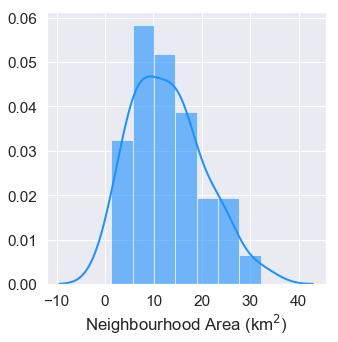

In [1262]:
print('Neighbourhoods {} have the largest area of {:,.0f} km²'.format\
      (statdata[statdata['Area']==statdata['Area'].max()]['Neighbourhood'].values[0],\
       statdata[statdata['Area']==statdata['Area'].max()]['Area'].values[0]))

plt.figure(figsize=(5,5))
sns.distplot(statdata['Area'],color='dodgerblue',bins='auto',**kwargs)
plt.xlabel('Neighbourhood Area (km$^2$)')
plt.show()

<br></br>
**Population Density Distribution** 
<br>
* Poppulation density seems normally distributed with a mean of about >2000/km<sup>2</sup>. 

Neighbourhoods Connaught, West Victoria Park have the highest population density of 6,786 residents/km²


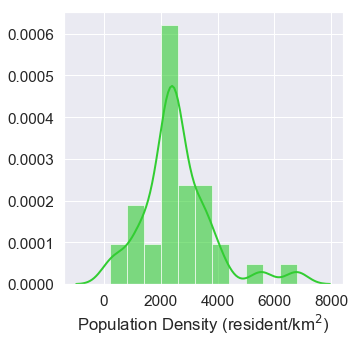

In [62]:
print('Neighbourhoods {} have the highest population density of {:,.0f} residents/km²'.format\
      (statdata[statdata['PopDensity']==statdata['PopDensity'].max()]['Neighbourhood'].values[0],\
       statdata[statdata['PopDensity']==statdata['PopDensity'].max()]['PopDensity'].values[0]))

plt.figure(figsize=(5,5))
sns.distplot(statdata['PopDensity'],color='limegreen',bins='auto',**kwargs)
plt.xlabel('Population Density (resident/km$^2$)')
plt.show()

<br></br>
**Average House Price Distribution**<br>
* Mode of average house price is between 300-400k C$. <br>
* The distribution appears to be skewed right. 

Neighbourhoods Elbow Park, Britannia, Parkhill, Mission have the highest average house price of 980,839 C$


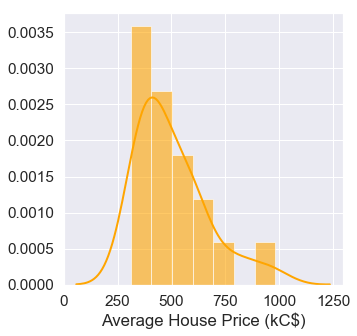

In [63]:
print('Neighbourhoods {} have the highest average house price of {:,.0f} C$'.format\
      (statdata[statdata['AvgHomePrice']==statdata['AvgHomePrice'].max()]['Neighbourhood'].values[0],\
       1000*statdata[statdata['AvgHomePrice']==statdata['AvgHomePrice'].max()]['AvgHomePrice'].values[0]))

plt.figure(figsize=(5,5))
sns.distplot(statdata['AvgHomePrice'],color='orange',bins='auto',**kwargs)
plt.xlabel('Average House Price (kC$)')
plt.show()

<br></br>
**Average House Price Map**
* Neighbourhoods next to downtown have the highest average house prices but the price in downtown is not high. 
* Northeast area seems to have low price. 

In [1213]:
map_house = folium.Map(location=[latitude,longitude],zoom_start=10)

bins = np.linspace(np.floor(statdata['AvgHomePrice'].min()/100)*100,\
                            np.ceil(statdata['AvgHomePrice'].max()/100)*100,10)

folium.Choropleth(
    geo_data=r'lfsa000a16a_e_simp_edit.json',
    data=statdata,
    columns=['FSA','AvgHomePrice'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.1,
    legend_name='Average House Price (kC$)', 
    bins=bins,
    reset=True).add_to(map_house)

folium.LayerControl().add_to(map_house)

for hp,lat,long in zip(statdata['AvgHomePrice'],statdata['Latitude'],statdata['Longitude']): 
    label = 'Average House Price: {:,.0f} kC$'.format(hp)
    lable = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long], radius=4, popup=label, color='crimson', 
                        fill=True, fill_color='#FFA500', fill_opacity=0, 
                        parse_html=False).add_to(map_house)
map_house

<br></br>
**Crime and Crime Rate Last 5 Years by PostalCode (FSA)** <br>
* Northeast areas have highest number of crimes. 
* Downtown has the highest crime rate. 

Neighbourhoods with highest crime: Penbrooke Meadows, Marlborough


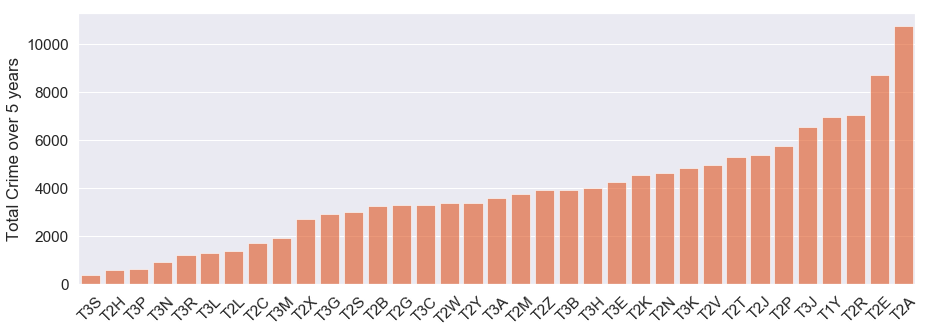

In [64]:
print('Neighbourhoods with highest crime:', \
      statdata[statdata['CrimeTotal']==statdata['CrimeTotal'].max()]['Neighbourhood'].values[0])

plt.figure(figsize=(15,5))
sns.barplot(x='FSA',y='CrimeTotal',data=statdata.sort_values('CrimeTotal'),color='orangered',alpha=0.6)
plt.ylabel('Total Crime over 5 years')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

Neighbourhoods with highest crime rate: City Centre, Calgary Tower


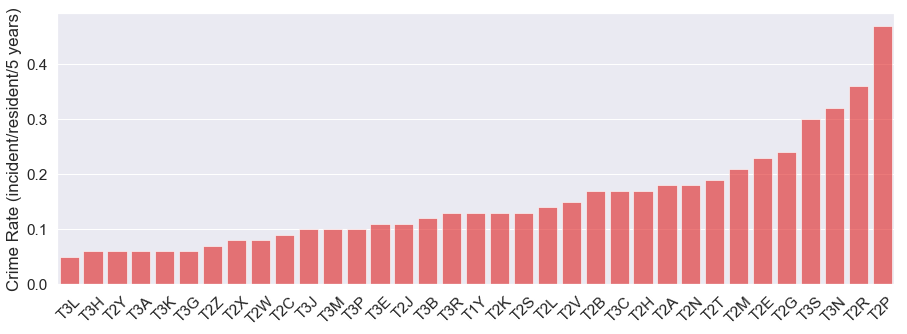

In [65]:
print('Neighbourhoods with highest crime rate:', \
      statdata[statdata['CrimeRate']==statdata['CrimeRate'].max()]['Neighbourhood'].values[0])
plt.figure(figsize=(15,5))
sns.barplot(x='FSA',y='CrimeRate',data=statdata.sort_values('CrimeRate'),color='red',alpha=0.6)
plt.ylabel('Crime Rate (incident/resident/5 years)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()


<br></br>
**Crime Rate Map**<br>
* Downtown and northeast neighbourhoods appear to have high crime rates. 

In [1260]:
map_crime = folium.Map(location=[latitude,longitude],zoom_start=10)

bins = np.linspace(np.floor(statdata['CrimeRate'].min()/0.05)*0.05,\
                   np.ceil(statdata['CrimeRate'].max()/0.05)*0.05,10)

folium.Choropleth(
    geo_data=r'lfsa000a16a_e_simp_edit.json',
    data=statdata,
    columns=['FSA','CrimeRate'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrBr',
    fill_opacity=0.5, 
    line_opacity=0.1,
    legend_name='Crime Rate over 5 years', 
    bins=bins,
    reset=True).add_to(map_crime)

folium.LayerControl().add_to(map_crime)

for cr,lat,long in zip(statdata['CrimeRate'],statdata['Latitude'],statdata['Longitude']): 
    label = 'Crime Rate: {0:.2f}'.format(cr)
    lable = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long], radius=4, popup=label, color='crimson', 
                        fill=True, fill_color='#FFA500', fill_opacity=0, 
                        parse_html=False).add_to(map_crime)
map_crime

<br></br>
**School Rating Map**<br>
* Schools in northeast neighbourhoods appear to have lower ratings. 

In [1261]:
map_school = folium.Map(location=[latitude,longitude],zoom_start=10)

bins = np.linspace(np.floor(statdata['AvgRatingElementary'].min(skipna=True)/0.5)*0.5,\
                   np.ceil(statdata['AvgRatingElementary'].max(skipna=True)/0.5)*0.5,10)

folium.Choropleth(
    geo_data=r'lfsa000a16a_e_simp_edit.json',
    data=statdata,
    columns=['FSA','AvgRatingElementary'],
    key_on='feature.properties.CFSAUID',
    fill_color='BuGn',
    fill_opacity=0.5, 
    line_opacity=0.1,
    legend_name='Average Elementary School Rating', 
    bins=bins,
    reset=True).add_to(map_school)
folium.LayerControl().add_to(map_school)

for sr,lat,long in zip(statdata['AvgRatingElementary'],statdata['Latitude'],statdata['Longitude']): 
    label = 'Average Elementary School Rating: {0:.1f}'.format(sr)
    lable = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long], radius=4, popup=label, color='crimson', 
                        fill=True, fill_color='#FFA500', fill_opacity=0, 
                        parse_html=False).add_to(map_school)
map_school

<br></br>
**House Price vs. Crime Rate, Population Density, Average School Rating**

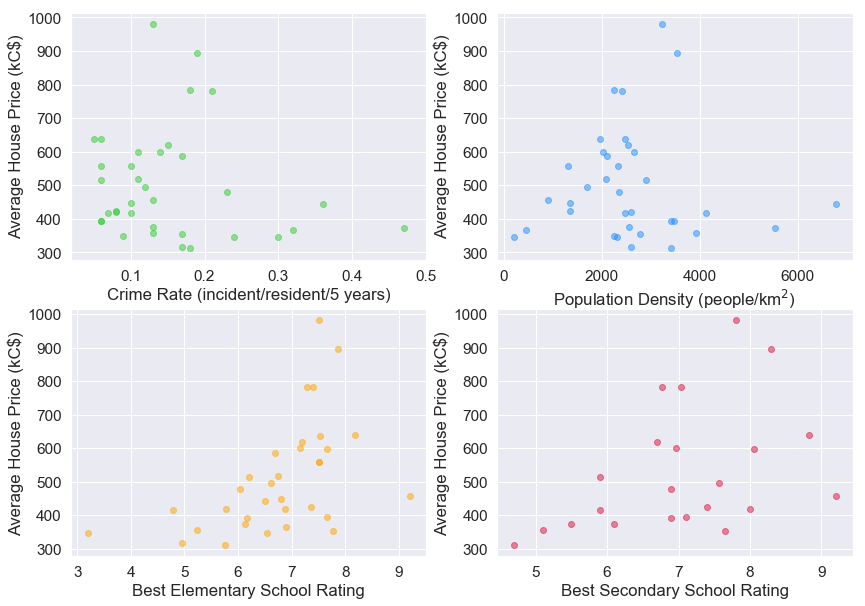

In [1106]:
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.scatter(statdata['CrimeRate'],statdata['AvgHomePrice'],color='limegreen',alpha=0.5)
plt.xlabel('Crime Rate (incident/resident/5 years)')
plt.ylabel('Average House Price (kC$)')

plt.subplot(2,2,2)
plt.scatter(statdata['PopDensity'],statdata['AvgHomePrice'],color='dodgerblue',alpha=0.5)
plt.xlabel('Population Density (people/km$^2$)')
plt.ylabel('Average House Price (kC$)')

plt.subplot(2,2,3)
plt.scatter(statdata['AvgRatingElementary'],statdata['AvgHomePrice'],color='orange',alpha=0.5)
plt.xlabel('Best Elementary School Rating')
plt.ylabel('Average House Price (kC$)')

plt.subplot(2,2,4)
plt.scatter(statdata['AvgRatingSecondary'],statdata['AvgHomePrice'],color='crimson',alpha=0.5)
plt.xlabel('Best Secondary School Rating')
plt.ylabel('Average House Price (kC$)')

plt.show()

### 3. VENUES DATA AND K-MEAN CLUSTERING<a name='clustering'></a>

#### 3.1. Venues Data Retrieval from FourSquare

In [71]:
CLIENT_ID = 'AJLIODOGAOKRUSCO0CA2YARCQ0SBZ1WPIJX3NVYOBXHUVKCG'
CLIENT_SECRET = 'PIGHWKRFV5NPKJ1WE2J2115EYRD01M3WU4GLUCLYYQVTQR0L'
VERSION = '20180605'

In [161]:
def getNearbyVenues(names, latitudes, longitudes, radii, limit=999):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['FSA', 
                  'FSA Latitude', 
                  'FSA Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [679]:
calgary_venues = getNearbyVenues(names=statdata['FSA'], 
                                 latitudes=statdata['Latitude'],
                                 longitudes=statdata['Longitude'], 
                                 radii=1000*np.sqrt(statdata['Area']/2))

T1Y
T2A
T2B
T2C
T2E
T2G
T2H
T2J
T2K
T2L
T2M
T2N
T2P
T2R
T2S
T2T
T2V
T2W
T2X
T2Y
T2Z
T3A
T3B
T3C
T3E
T3G
T3H
T3J
T3K
T3L
T3M
T3N
T3P
T3R
T3S


In [680]:
print('Neighbourhoods that Foursquare returns no venue:', ', '.join(list(np.setdiff1d(calgary['FSA'],calgary_venues['FSA']))))

Neighbourhoods that Foursquare returns no venue: 


Number of unique categories: 200
Neighbourhoods with highest number of venues:  Braeside, Woodbine


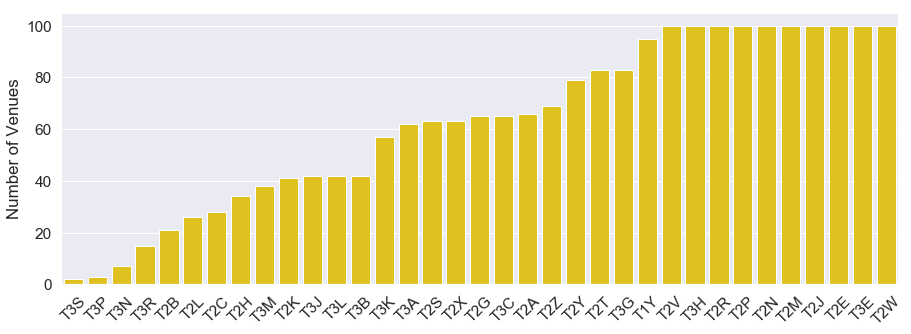

In [1173]:
print('Number of unique categories:',len(calgary_venues['Venue Category'].unique()))
print('Neighbourhoods with highest number of venues: ', 
      ', '.join(calgary[calgary['FSA'].isin(calgary_venues.groupby('FSA').count().\
                                            sort_values('Venue',ascending=False).\
                                            reset_index().loc[:0,'FSA'])]['Neighbourhood'].to_list()))

plt.figure(figsize=(15,5))
sns.barplot(x='FSA',y='Venue',\
            data=calgary_venues.groupby('FSA').count().sort_values('Venue').reset_index(),\
            color='gold')
plt.ylabel('Number of Venues')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

#### 3.2. Data Preparation for Clustering and Mapping

##### One-hot Encoding of Revenue Categories

In [682]:
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix='',prefix_sep='')
calgary_onehot['FSA'] = calgary_venues['FSA']

columns = [calgary_onehot.columns[-1]]+list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[columns]
calgary_grouped = calgary_onehot.groupby('FSA').mean().reset_index()

##### Neighbourhood Clusters and 10 Most Common Venues

In [683]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [684]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['FSA']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
calgary_venues_sorted = pd.DataFrame(columns=columns)
calgary_venues_sorted['FSA'] = calgary_grouped['FSA']

for ind in np.arange(calgary_grouped.shape[0]):
    calgary_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

#### 3.3. K-means Clustering

In [945]:
# only venue data
calgary_grouped_clustering = calgary_grouped.drop('FSA',axis=1)
# calgary_grouped_clustering = calgary_grouped_clustering.drop(calgary_grouped_clustering.T\
#                                                              [calgary_grouped_clustering.sum(axis=0)<0.05].\
#                                                              index.to_list(), axis=1)
calgary_grouped_clustering.head()

African Restaurant  Airport  Airport Terminal  American Restaurant  \
0            0.000000     0.00              0.00                 0.00   
1            0.015152     0.00              0.00                 0.00   
2            0.000000     0.00              0.00                 0.00   
3            0.000000     0.00              0.00                 0.00   
4            0.000000     0.02              0.03                 0.05   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  BBQ Joint  \
0             0.010526          0.042105                0.00        0.0   
1             0.000000          0.030303                0.00        0.0   
2             0.000000          0.047619                0.00        0.0   
3             0.000000          0.000000                0.00        0.0   
4             0.010000          0.010000                0.01        0.0   

   Bakery      Bank       Bar  Baseball Field  Beach  Beer Garden  Beer Store  \
0     0.0  0.021053  0.000000             0.0    0.0          0.0         0.0   
1     0.0  0.030303  0.015152             0.0    0.0          0.0         0.0   
2     0.0  0.000000  0.047619             0.0    0.0          0.0         0.0   
3     0.0  0.000000  0.035714             0.0    0.0          0.0         0.0   
4     0.0  0.000000  0.000000             0.0    0.0          0.0         0.0   

   Big Box Store  Bistro  Bookstore  Bowling Alley  Brazilian Restaurant  \
0            0.0     0.0   0.010526       0.000000                   0.0   
1            0.0     0.0   0.000000       0.015152                   0.0   
2            0.0     0.0   0.000000       0.000000                   0.0   
3            0.0     0.0   0.000000       0.000000                   0.0   
4            0.0     0.0   0.010000       0.010000                   0.0   

   Breakfast Spot   Brewery  Bubble Tea Shop  Burger Joint  Bus Stop  \
0        0.021053  0.000000              0.0      0.021053       0.0   
1        0.000000  0.015152              0.0      0.000000       0.0   
2        0.000000  0.000000              0.0      0.000000       0.0   
3        0.000000  0.000000              0.0      0.000000       0.0   
4        0.010000  0.030000              0.0      0.040000       0.0   

   Business Service  Café  Cajun / Creole Restaurant  Camera Store  \
0               0.0   0.0                        0.0           0.0   
1               0.0   0.0                        0.0           0.0   
2               0.0   0.0                        0.0           0.0   
3               0.0   0.0                        0.0           0.0   
4               0.0   0.0                        0.0           0.0   

   Candy Store  Casino  Cheese Shop  Chinese Restaurant  Clothing Store  \
0          0.0     0.0          0.0            0.000000        0.031579   
1          0.0     0.0          0.0            0.015152        0.000000   
2          0.0     0.0          0.0            0.000000        0.000000   
3          0.0     0.0          0.0            0.000000        0.000000   
4          0.0     0.0          0.0            0.020000        0.010000   

   Cocktail Bar  Coffee Shop  College Gym  Comedy Club  Comic Shop  \
0           0.0     0.073684          0.0          0.0    0.000000   
1           0.0     0.090909          0.0          0.0    0.000000   
2           0.0     0.000000          0.0          0.0    0.000000   
3           0.0     0.142857          0.0          0.0    0.035714   
4           0.0     0.080000          0.0          0.0    0.000000   

   Concert Hall  Construction & Landscaping  Convenience Store  \
0           0.0                    0.010526           0.052632   
1           0.0                    0.000000           0.121212   
2           0.0                    0.000000           0.190476   
3           0.0                    0.000000           0.035714   
4           0.0                    0.000000           0.000000   

   Cosmetics Shop  Costume Shop  Cupcake Shop 

##### Selection of Number of Clusters

In [946]:
n_clusters_range = np.arange(1,31,1)
distortion = []

for n in n_clusters_range: 
    tempmodel = KMeans(n_clusters=n,n_init=100,max_iter=400,n_jobs=4,random_state=100)
    tempmodel.fit(calgary_grouped_clustering)
    distortion.append(tempmodel.inertia_)

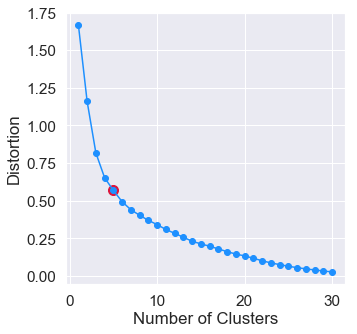

In [1020]:
plt.figure(figsize=(5,5))
plt.plot(n_clusters_range,distortion,marker='o',color='dodgerblue')
plt.scatter(5,distortion[4],color='crimson',s=100)
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [977]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters,n_init=100,max_iter=400,n_jobs=4,random_state=100)
kmeans.fit(calgary_grouped_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=400,
    n_clusters=5, n_init=100, n_jobs=4, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

##### Mapping Clusters

In [978]:
calgary_map = calgary_venues_sorted
calgary_map['Cluster Labels'] = kmeans.labels_
calgary_map = pd.merge(calgary_map.set_index('FSA'),calgary[['FSA','Neighbourhood','Latitude','Longitude']],\
                       how='left',on='FSA')
fixed_columns = [calgary_map.columns[0]]+list(calgary_map.columns[-3:])+[calgary_map.columns[1]]+list(calgary_map.columns[2:-3])
calgary_map = calgary_map[fixed_columns]

In [1212]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

bins = np.linspace(np.floor(statdata['AvgHomePrice'].min()/100)*100,\
                            np.ceil(statdata['AvgHomePrice'].max()/100)*100,10)

# add house price layer
folium.Choropleth(
    geo_data=r'lfsa000a16a_e_simp_edit.json',
    data=statdata,
    columns=['FSA','AvgHomePrice'],
    key_on='feature.properties.CFSAUID',
    fill_color='GnBu',
    fill_opacity=0.9, 
    line_opacity=0.9,
    legend_name='Average House Price (kC$)', 
    bins=bins,
    reset=True).add_to(map_clusters)
folium.LayerControl().add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(calgary_map['Latitude'], calgary_map['Longitude'], calgary_map['Neighbourhood'], calgary_map['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

##### 10 Most Common Venue Categories for Each Cluster

In [986]:
calgary_map.loc[calgary_map['Cluster Labels']==0,calgary_map.columns[[1]+list(range(5,calgary_map.shape[1]))]]

Neighbourhood  2nd Most Common Venue  \
4                     Bridgeland, Greenview, Zoo, YYC            Coffee Shop   
5   Inglewood, Burnsland, Chinatown, East Victoria...                  Diner   
6                         Highfield, Burns Industrial      Korean Restaurant   
7   Queensland Downs, Lake Bonavista, Willow Park,...                    Pub   
10          Mount Pleasant, Capitol Hill, Banff Trail                    Pub   
11         Kensington, Westmont, Parkdale, University    American Restaurant   
12                         City Centre, Calgary Tower                    Pub   
13                      Connaught, West Victoria Park             Restaurant   
14           Elbow Park, Britannia, Parkhill, Mission            Pizza Place   
15                       Altadore, Bankview, Richmond  Vietnamese Restaurant   
16       Oak Ridge, Haysboro, Kingsland, Windsor Park                    Pub   
17                                 Braeside, Woodbine                    Pub   
23         Rosscarrock, Wildwood, Shaganappi, Sunalta    Sporting Goods Shop   

   3rd Most Common Venue  4th Most Common Venue   5th Most Common Venue  \
4    American Restaurant  Vietnamese Restaurant    Fast Food Restaurant   
5             Restaurant                Brewery                    Café   
6     Mexican Restaurant       Department Store  Furniture / Home Store   
7             Restaurant          Grocery Store        Sushi Restaurant   
10        Sandwich Place                   Café        Sushi Restaurant   
11        Ice Cream Shop                    Pub                    Café   
12            Steakhouse                   Café             Coffee Shop   
13                   Pub     Italian Restaurant              Steakhouse   
14                  Café                    Bar      Mexican Restaurant   
15           Pizza Place                    Pub          Sandwich Place   
16      Sushi Restaurant         Sandwich Place   Vietnamese Restaurant   
17        Sandwich Place       Sushi Restaurant             Supermarket   
23                   Pub                   Park             Coffee Shop   

     6th Most Common Venue      7th Most Common Venue  \
4              Pizza Place               Burger Joint   
5           Farmers Market                Pizza Place   
6         Sushi Restaurant        Sporting Goods Shop   
7   Furniture / Home Store       Fast Food Restaurant   
10               Gastropub                       Park   
11        Sushi Restaurant               Burger Joint   
12                     Bar  Middle Eastern Restaurant   
13                     Bar                Pizza Place   
14              Restaurant                       Park   
15                 Dog Run         Mexican Restaurant   
16        Department Store       Fast Food Restaurant   
17    Fast Food Restaurant                Pizza Place   
23    Fast Food Restaurant             Ice Cream Shop   

        8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
4            Airport Terminal               Brewery     Italian Restaurant   
5          Chinese Restaurant            Sports Bar            Music Store   
6                  Steakhouse           Gas Station         Discount Store   
7       Vietnamese Restaurant   Sporting Goods Shop           Burger Joint   
10                 Restaurant   American Restaurant     Chinese Restaurant   
11               Concert Hall        Breakfast Spot                  Hotel   
12                     Bakery     French Restaurant         Breakfast Spot   
13                       Café               Brewery           Cocktail Bar   
14                   Pharmacy           Music Store                Brewery   
15                      Diner  Fast Food Restaurant         Breakfast Spot   
16             Clothing Store            Steakhouse           Burger Joint   
17  Middle Eastern Restaurant          Liquor Store             Restaurant   
23          Convenience Store               Theater    

In [906]:
calgary_map.loc[calgary_map['Cluster Labels']==4,calgary_map.columns[[1]+list(range(5,calgary_map.shape[1]))]]

Neighbourhood 2nd Most Common Venue  \
0                    Rundle, Whitehorn, Monterey Park        Sandwich Place   
1                      Penbrooke Meadows, Marlborough         Grocery Store   
2                      Forest Lawn, Dover, Erin Woods        Sandwich Place   
3   Lynnwood Ridge, Ogden, Foothills Industrial, G...  Fast Food Restaurant   
8                                Thornecliffe, Tuxedo  Fast Food Restaurant   
9                   Brentwood, Collingwood, Nose Hill     Convenience Store   
18                                Midnapore, Sundance  Fast Food Restaurant   
19          Millrise, Somerset, Bridlewood, Evergreen  Fast Food Restaurant   
20  Douglas Glen, McKenzie Lake, Copperfield, East...           Gas Station   
21       Dalhousie, Edgemont, Hamptons, Hidden Valley           Pizza Place   
22     Montgomery, Bowness, Silver Springs, Greenwood  Fast Food Restaurant   
24           Lakeview, Glendale, Killarney, Glamorgan           Pizza Place   
25      Hawkwood, Arbour Lake, Royal Oak, Rocky Ridge  Fast Food Restaurant   
26  Discovery Ridge, Signal Hill, Aspen Woods, Pat...         Grocery Store   
27    Martindale, Taradale, Falconridge, Saddle Ridge     Convenience Store   
28  Sandstone, Harvest Hills, Coventry Hills, Pano...                 Hotel   
29                              Tuscany, Scenic Acres  Fast Food Restaurant   
30                                           Cranston         Grocery Store   
33                                          Northwest         Grocery Store   

    3rd Most Common Venue  4th Most Common Venue  \
0             Pizza Place      Convenience Store   
1             Coffee Shop         Sandwich Place   
2                   Diner          Grocery Store   
3             Golf Course               Pharmacy   
8   Vietnamese Restaurant       Department Store   
9             Coffee Shop           Burger Joint   
18          Grocery Store               Pharmacy   
19            Pizza Place          Grocery Store   
20            Pizza Place         Sandwich Place   
21            Gas Station         Ice Cream Shop   
22                   Park      Convenience Store   
24   Fast Food Restaurant               Pharmacy   
25            Gas Station               Pharmacy   
26             Restaurant   Fast Food Restaurant   
27            Pizza Place            Coffee Shop   
28          Grocery Store  Vietnamese Restaurant   
29            Gas Station               Pharmacy   
30                   Café         Sandwich Place   
33            Coffee Shop         Farmers Market   

            5th Most Common Venue 6th Most Common Venue  \
0            Fast Food Restaurant      Asian Restaurant   
1           Vietnamese Restaurant  Fast Food Restaurant   
2            Fast Food Restaurant                   Bar   
3                  Sandwich Place                   Pub   
8            Gym / Fitness Center     Convenience Store   
9          Furniture / Home Store                  Park   
18                    Golf Course     Recreation Center   
19                            Pub     Convenience Store   
20              Convenience Store                   Gym   
21                 Sandwich Place                   Gym   
22                    Gas Station           Golf Course   
24              Convenience Store         Grocery Store   
25              Convenience Store           Pizza Place   
26                    Pizza Place              Pharmacy   
27                 Sandwich Place  Fast Food Restaurant   
28                            Gym           Golf Course   
29                   Liquor Store                  Park   
30                  Shopping Mall           Gas Station   
33  Paper / Office Supplies Store         Big Box Store   

    7th Most Common Venue       8th Most Common Venue   9th Most Common Venue  \
0   Vietnamese Restaurant                 Gas Station            Liquor Store   
1                Pharmacy            Asian Restaurant      Italian Restaura

In [985]:
calgary_map.loc[(calgary_map['Cluster Labels']==1)|(calgary_map['Cluster Labels']==2)|(calgary_map['Cluster Labels']==3) ,calgary_map.columns[[1]+list(range(5,calgary_map.shape[1]))]]

Neighbourhood       2nd Most Common Venue 3rd Most Common Venue  \
31      Northeast                   Gastropub        Sandwich Place   
32  Symons Valley  Construction & Landscaping        Shop & Service   
34      Southeast                  Print Shop   Filipino Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
31                   Spa          Home Service           Gas Station   
32           Yoga Studio  Fast Food Restaurant         Garden Center   
34             Gastropub           Gas Station         Garden Center   

     7th Most Common Venue   8th Most Common Venue 9th Most Common Venue  \
31    Fast Food Restaurant  Furniture / Home Store    Frozen Yogurt Shop   
32  Furniture / Home Store      Frozen Yogurt Shop   Fried Chicken Joint   
34  Furniture / Home Store      Frozen Yogurt Shop   Fried Chicken Joint   

   10th Most Common Venue  Cluster Labels  
31    Fried Chicken Joint               3  
32      French Restaurant               1  
34      French Restaurant               2

### 4. HOUSE PRICE REASONING WITH RANDOM FOREST<a name='randomforest'></a>

#### 4.1. Data Preparation

In [1224]:
x = pd.merge(statdata.drop(['Neighbourhood','AvgHomePrice'],axis=1),\
             calgary_venues.groupby('FSA').count()[['Venue']],how='left',on='FSA')
x.rename(columns={'Venue':'NVenue'},inplace=True)
x['VenueDensity'] = x['NVenue']/x['Area']
x['EleRate'] = x['NElementary']/x['Population']
x['SecRate'] = x['NSecondary']/x['Population']

x.fillna(0,inplace=True)
x.drop(['FSA','Population','Area','CrimeTotal','NElementary','NSecondary',\
       'Latitude','Longitude','NVenue'],axis=1,inplace=True)
x.head()

CrimeRate  PopDensity  AvgRatingElementary  MaxRatingElementary  \
0       0.13        3921                 5.24                  7.7   
1       0.18        3406                 5.76                  7.4   
2       0.17        2604                 4.95                  5.0   
3       0.09        2242                 6.53                  6.8   
4       0.23        2345                 6.04                  9.0   

   AvgRatingSecondary  MaxRatingSecondary  VenueDensity   EleRate   SecRate  
0                 5.1                 5.1      6.884058  0.000314  0.000018  
1                 4.7                 5.7      3.793103  0.000118  0.000034  
2                 0.0                 0.0      2.837838  0.000104  0.000000  
3                 0.0                 0.0      3.414634  0.000163  0.000000  
4                 6.9                 6.9      6.172840  0.000289  0.000026

In [1225]:
y = statdata['AvgHomePrice'].ravel()

In [1248]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=8)

#### 4.2. Random Forest

In [1249]:
forest = RandomForestRegressor(n_estimators=1000,n_jobs=-1,random_state=10)
forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

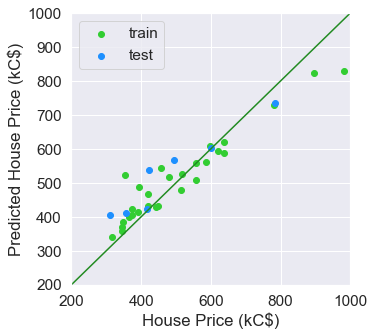

In [1257]:
plt.figure(figsize=(5,5))
plt.scatter(y_train,forest.predict(x_train),color='limegreen',label='train')
plt.scatter(y_test,forest.predict(x_test),color='dodgerblue',label='test')
plt.plot([200,1000],[200,1000],color='forestgreen')
plt.xlabel('House Price (kC$)')
plt.ylabel('Predicted House Price (kC$)')
plt.xlim((200,1000))
plt.ylim((200,1000))
plt.legend()
plt.show()

#### 4.3. Feature Importance and Pricing Evaluation

* School ratings and venue density appear to be the most important variables. 
* Houses in T2S are the most overpriced while ones in T2H are the most underpriced. 

No handles with labels found to put in legend.


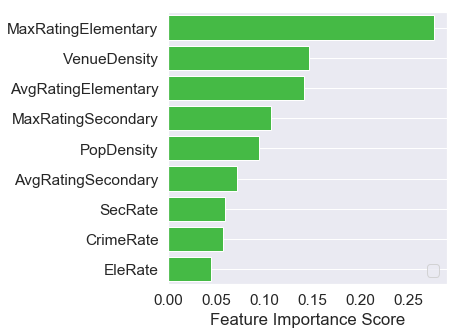

In [1259]:
feature_imp = pd.Series(forest.feature_importances_,index=x.columns).sort_values(ascending=False)
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(5,5))
sns.barplot(x=feature_imp, y=feature_imp.index,color='limegreen')
plt.xlabel('Feature Importance Score')
plt.grid()
plt.legend()
plt.show()

In [1252]:
compare = pd.DataFrame([y,forest.predict(x)]).T
compare.columns = ['AvgHomePrice','PredAvgHomePrice']
compare = pd.merge(compare,statdata[['FSA','Neighbourhood','AvgHomePrice']],'left','AvgHomePrice')
compare['House Overpricing Ratio'] = (compare['AvgHomePrice'] - compare['PredAvgHomePrice'])/compare['AvgHomePrice']

Neighbourhoods with the most overpriced houses:  Elbow Park, Britannia, Parkhill, Mission
Neighbourhoods with the most underpriced houses:  Highfield, Burns Industrial


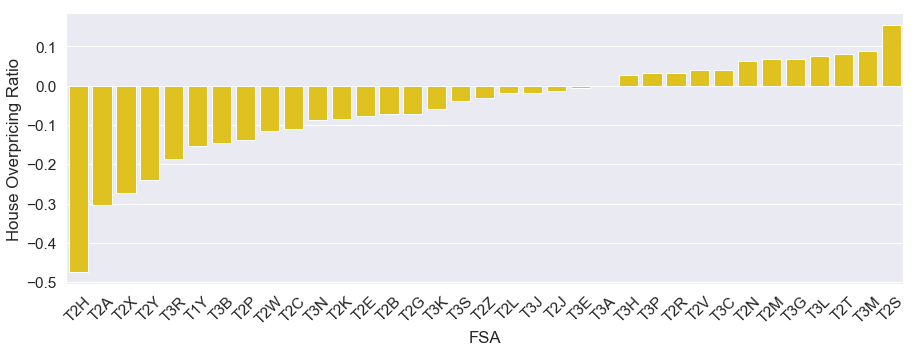

In [1253]:
print('Neighbourhoods with the most overpriced houses: ', \
      compare.sort_values('House Overpricing Ratio')['Neighbourhood'].values[-1])
print('Neighbourhoods with the most underpriced houses: ', \
      compare.sort_values('House Overpricing Ratio')['Neighbourhood'].values[0])

plt.figure(figsize=(15,5))
sns.barplot('FSA','House Overpricing Ratio',data=compare.sort_values('House Overpricing Ratio'),color='gold')
plt.xticks(rotation=45)
plt.show()

### 5. CONCLUSIONS<a name='conclusions'></a>

In conclusion: 
* Insight information about several statistics of neighbourhoods in Calgary such as population density, crime rate, school ratings, average house prices was provided through exploratory data analysis. 
* More than 30 forward sortation areas in Calgary were grouped into 5 clusters based on their venues through k-mean clustering. 
* Average house price in each neighbourhood was modelled by random forest regression and driving variables were identified. 

However, the results can still be improved: 
* Coordinates of neighbourhood centers are important as they dictate how venues are queried in Foursquare. An algorithm to calculate center coordinates from boundary file will probably yield more reliable coordinates than GeoNames and Mapawi. 
* If Foursquare limit on the number of venues returned by each query is raised and more importantly if accessing to venue ratings is granted, the result of clustering will probably be significantly improved.
* Large amounts of demographic data of each neighbourhood such as age, income, occupation etc. available on Statistics Canada can be included. 